
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

#### Notebook responsavel pelo pré-processamento dos textos das bases;
- Realizamos todo processamento de texto com exceção das ngrams e frequência menor que 5, onde estes dois parâmetros ajustamos utilizando TfidfVectorizer quando necessário.
- Quando necessário realizamos o balanceamento das classes;
- No final do pré-processamento, salvamos dataset pré-processado.

#### Importação de bibliotecas

In [3]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import matplotlib.pyplot as plt

#### Tarefa: Classificação de ratings das avaliações de clientes:
- 4 e 5: Positiva
- 1 e 2: Negativa
- 3: Descartadas


#### Importação do dataset

In [10]:
df = pd.read_csv('../datasets/buscape.csv')

In [11]:
df.head(2)

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,4_55516,"Estou muito satisfeito, o visor é melhor do qu...","estou muito satisfeito, o visor e melhor do qu...","['estou', 'muito', 'satisfeito', 'visor', 'mel...",1.0,4,1,1
1,minus_1_105339,"""muito boa\n\nO que gostei: preco\n\nO que não...","""muito boa\n\no que gostei: preco\n\no que nao...","['muito', 'boa', 'que', 'gostei', 'preco', 'qu...",1.0,5,1,1


#### Removendo colunas que não serão utilizadas

In [12]:
columns_to_remove = ['original_index', 'review_text_processed', 'review_text_tokenized', 'polarity', 'kfold_polarity', 'kfold_rating']

In [13]:
df = df.drop(columns=columns_to_remove, axis=1)

In [14]:
df.head(3)

,review_text,rating
0,"Estou muito satisfeito, o visor é melhor do qu...",4
1,"""muito boa\n\nO que gostei: preco\n\nO que não...",5
2,"Rápida, ótima qualidade de impressão e fácil d...",5


In [15]:
# Caso necessite renomear as colunas
#new_column_names = {
 #   'alvo' : 'rating',
  #  'textoProcessado' : 'review_text'
#}

In [8]:
#df.rename(columns=new_column_names, inplace=True)

In [21]:
print(f'dataset original : {df.shape[0]} instancias, {df.shape[1]} classes')

dataset original : 84991 instancias, 2 classes


#### Pré-processamento

#### Verificando registros nulos

In [22]:
df.isnull().any()

review_text     True
rating         False
dtype: bool

In [23]:
df['review_text'].isnull().sum()

1

In [24]:
df[df['review_text'].isnull()]

,review_text,rating
38852,NaN,4


#### Removendo registros nulos

In [25]:
df = df.dropna()

In [26]:
df.isnull().any()

review_text    False
rating         False
dtype: bool

In [27]:
df.shape

(84990, 2)

#### Padronizando texto em lowercase

In [28]:
def to_lowercase(text):
    text = text.apply(lambda x: " ".join(x.lower().split()) if isinstance(x, str) else "")
    return text

In [29]:
df["review_text"] = to_lowercase(df["review_text"])

#### Removendo caracteres especiais e substituindo cedilhas por c

In [30]:
def preprocess_text(text):
    # removendo caracteres especiais
    text = re.sub(r'[^\w\s]', '', text)
    # unidecode translitera caracteres acentuados e especiais para formas sem acento ou caracteres equivalentes
    text = unidecode(text)
    return text

In [31]:
df['review_text'] = [preprocess_text(doc) for doc in df['review_text']]

#### Removendo hiperlinks

In [32]:
def remove_hiperlink(text):
    text = re.sub(r"(https?://[^\s]+|www\.[^\s]+)", '', text)
    return text

In [33]:
df['review_text'] = [remove_hiperlink(doc) for doc in df['review_text']]

#### Descartando instâncias com avaliação igual a 3

In [34]:
rating_3 = df['rating'] == 3
rating_3.sum()

11364

In [35]:
df = df[df['rating'] != 3]

In [36]:
df.shape

(73626, 2)

#### Ajustando ratings:
- 1 e 2 = 0
- 4 e 5 = 1

In [37]:
# Caso necessite binarização
df['rating'] = list(map(lambda x: 0 if x<=2 else 1, df['rating']))

In [44]:
df_rating_counts = df['rating'].value_counts()
df_rating_counts

rating
1    66816
0     6810
Name: count, dtype: int64

#### Nota-se que o dataset está desbalanceado
- Existem mais avalições positivas do que negativas;
- Muito desproporcional:

In [48]:
print(f'positivas: {df_rating_counts[1]}')
print(f'negativas: {df_rating_counts[0]}')

positivas: 66816
negativas: 6810


In [49]:
def plot_barchart(data):
    rating_counts = data
    labels = [f'{data[1]} Avaliações Positivas', f'{data[0]} Avaliações Negativas']

    # Criar o gráfico de barras
    plt.bar(labels, rating_counts)

    # Adicionar rótulos e título
    plt.xlabel('Ratings')
    plt.ylabel('Contagem')
    plt.title('Gráfico de Barras de Ratings')

    # Mostrar o gráfico
    plt.show()

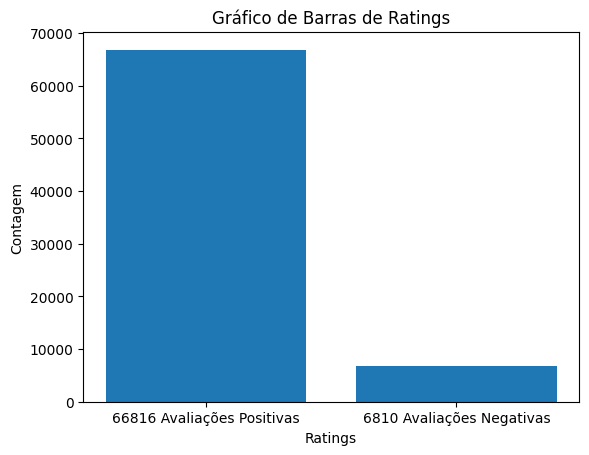

In [50]:
plot_barchart(df_rating_counts)

#### Utilizar a técnica de reamostragem RandomOverSampler para resolver o problema de desbalanceamento das classes
- Esta técnica gera novas amostras aleatórias para a classe minoritária;
- Desta forma tenta igualar número de amostras da classe majoritária;

In [71]:
from imblearn.over_sampling import RandomOverSampler

In [72]:
# Gerando uma cópia do dataset
df_balanced = df.copy()

In [73]:
ros = RandomOverSampler()

#### Separarando os recursos (X) e os rótulos (y)

In [74]:
# Alterarando o shape dos dados para uma representação com uma única coluna
# Os dados foram mantidos, mas agora X possui uma coluna adicional, tornando-se uma matriz bidimensional em vez de uma matriz unidimensional
X = np.array(df_balanced['review_text'])
X = X.reshape(-1, 1)

In [75]:
y = df_balanced['rating']

In [76]:
# Aplicando o RandomOverSampler para gerar novas amostras
X_res, y_res = ros.fit_resample(X, y)

In [77]:
print(pd.Series(y_res).value_counts())

rating
1    66816
0    66816
Name: count, dtype: int64


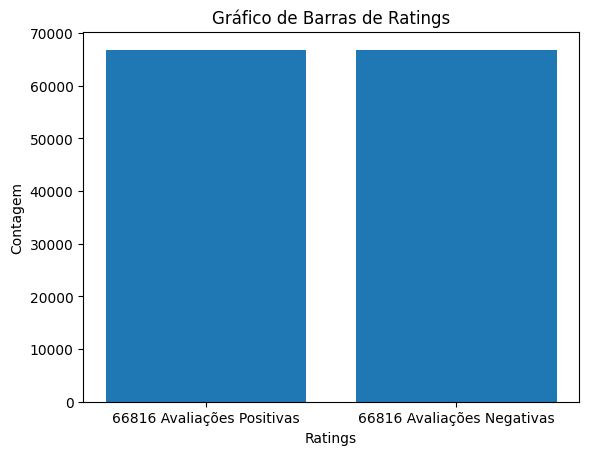

In [78]:
plot_barchart(y_res.value_counts())

In [79]:
def clear_sentences(sentences):
    new_list_texts = []
    for item in sentences:
        item = str(item)
        item_fixed = item[1:-1]  
        new_list_texts.append(item_fixed)
    
    return [s[1:-1] for s in new_list_texts]

In [80]:
texts = clear_sentences(X_res)
labels = y_res

In [81]:
df_balanced = {
    'review_text' : texts,
    'rating' : labels
}

In [82]:
preprocessed_balanced_df = pd.DataFrame(df_balanced)

In [83]:
preprocessed_balanced_df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


In [84]:
preprocessed_balanced_df.shape

(133632, 2)

In [85]:
preprocessed_balanced_df['rating'].value_counts()

rating
1    66816
0    66816
Name: count, dtype: int64

In [86]:
print(f'Após pré-processamento e balanceamento, a base buscape está com {preprocessed_balanced_df.shape[0]} instâncias')

Após pré-processamento e balanceamento, a base buscape está com 133632 instâncias


In [87]:
preprocessed_balanced_df.to_csv('../datasets/buscape_preprocessed.csv', index=False)